In [1]:
from jax import jit, vmap, random
import jax.numpy as np
import numpy as onp
import jax

# enable float 64
from jax.config import config

# config.update('jax_enable_x64', True)

In [2]:
from utils_response import create_df_response
import pandas as pd
import datetime


# How to use the Iterated EAKF

## Define the your process model $f$, your observational model $g$ and the initial guess of the state space $f_0$ 
- See code below
- We use binomial transition between compartments such that the number of people transitioning from compartment X to compartment Y at rate $\tau$ will be:
$$N_{X\rightarrow Y} \sim \text{Binom}\left(X,  1-\exp\left(\tau\cdot \Delta t\right)\right)$$

Note that here $\tau$ could be a function of $Y$ (Force of Infection for example), and that the process model also account for the step size $\Delta t$. In general, the step size can be embedded in the parameters of the model, but as a good practice we keep in as an argument of the process model with defualt to one $\Delta t=1$.

In [3]:
# https://github.com/google/jax/issues/10144
def binomial_transition(xi, τ, dt=1):
    kb    = np.maximum(1.0 - np.exp(-τ*dt), 0)
    pop   = onp.random.binomial(onp.int64(xi), kb )
    return jax.device_put(pop)

def checkpopvars(x, pop):
    return np.clip(x, 0, pop)

def f(t, x, β, γ, N, dt=1):
    """
    Process model
    """
    S = x.at[0, :].get()
    I = x.at[1, :].get()
    R = x.at[2, :].get()
    C = x.at[3, :].get()


    s2i = binomial_transition(S, β * I / N, dt)
    i2r = binomial_transition(I, γ, dt)

    S  = S - s2i
    I  = I + s2i - i2r
    R  = R + i2r
    C  = s2i

    return np.array([S, I, R, C])

def g(t, x, θ, ρ=0.3):
    """
    Observational model.
        Args:
            t: time
            x: state space
            θ: parameters
            ρ: report rate
    """
    y = onp.random.binomial(onp.int64(x.at[3, :].get()), ρ)
    return jax.device_put(y)

def f0(pop=1e6, inf_init=1/100, m=300):
    """
    Initial guess of the state space.
    """
    I0 = pop * inf_init
    S0 = pop - I0
    R0 = 0
    C0 = 0

    x0 = np.ones((4, m)) * np.expand_dims(np.array([S0, I0, R0, C0]), -1)

    return x0

## Simulate the model to have one stochastic trajectory for ingest in the Iterated EAKF.

In [4]:
N = 1e6

γ_truth = 1/5 # days
β_truth = 3 * γ_truth # days

T    = 70
dt   = 1
ens  = 500
x0    = f0(N, 1/100, m=ens)
x_sim = x0

x_sim = np.full((4, T, ens), np.nan)
x_sim = x_sim.at[:, 0, :].set(x0)

for t in range(1, T):
    x     = f(t, x_sim.at[:, t-1, :].get(), β_truth, γ_truth, N)
    x_sim = x_sim.at[:, t, :].set(x)

C =  x_sim.at[3, :, :].get()

k = jax.random.PRNGKey(1)

obs_use   = C.at[:, onp.random.randint(ens)].get()
obs_use_n = obs_use# + np.squeeze(jax.random.normal(k, shape=(T, 1))*0.5), 0)


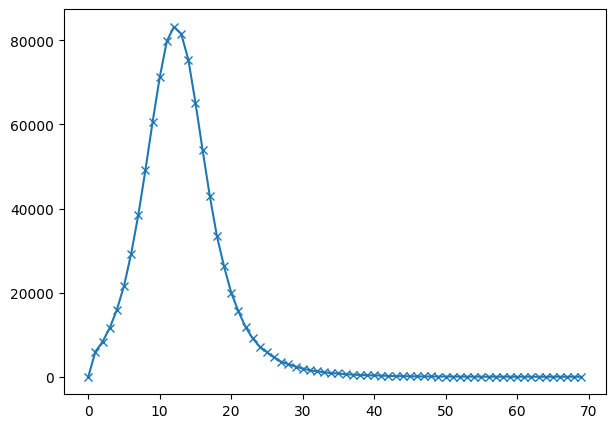

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(obs_use_n, label='obs', marker="x")

In [6]:
observation_df          = pd.DataFrame(obs_use_n, columns=['y1'])
observation_df["oev1"]  = np.maximum(20, 1 +( 0.1 * observation_df["y1"].values)**2)
observation_df["date"] = pd.date_range(start=datetime.datetime(2020, 1, 1), periods=T, freq='D')


In [7]:
from ifeakf import ifeakf

model_settings = {
    "m"           : 500,                           # number of ensembles
    "p"           : 2,                             # number of parameters
    "k"           : 1,                             # number of observations
    "n"           : 4,                             # number of state variables / dimension of the state space
    "dt"          : 1,                             # time step
    "param_name"  : ["β", "γ"],                    # name of the parameters
    "dates"       : observation_df["date"].values, # integration dates (for the process model) | date_{t+1}-date_t = dt
    "param_truth" : [β_truth, γ_truth]             # true parameter values (not required - just for the example)
    }

if_settings = {
   "Nif"                : 50,                           # number of iterations of the IF
   "type_cooling"       : "geometric",                  # type of cooling schedule
   "shrinkage_factor"   : 0.9,                          # shrinkage factor for the cooling schedule
   "inflation"          : 1.01,                         # inflation factor for spreading the variance after the EAKF step
   "assimilation_dates" : observation_df["date"].values # assimilation dates (for the inference)
}

# Function to be used for the ikeafk function.
f_if  = lambda t, x, θ: f(t, x, θ.at[0, :].get(), θ.at[1, :].get(), N)
g_if  = lambda t, x, θ: g(t, x, θ)
f0_if = lambda θ: f0(pop=N, inf_init=10/100, m=model_settings["m"])

γmin = 1/15
γmax = 1/3

βmin = 0.5 * γmin
βmax = 3   * γmax


state_space_range = np.array([[0, N], [0, N], [0, N], [0, N]])
parameters_range  = np.array([[βmin, βmax], [γmin, γmax]])

σ_perturb   = np.array([(βmax-βmin) / 2, (γmax-γmin) / 2] )


In [8]:
obs_df                  = observation_df.set_index("date").resample("W-Sun").sum()
obs_df.index.values[-1] = model_settings["dates"][-1]
obs_df["oev1"]  = np.maximum(20, 1 +( 0.2 * obs_df["y1"].values)**2)

if_settings["assimilation_dates"] = obs_df.index.values

θmle, θpost = ifeakf(process_model            = f_if,
                    observational_model       = g_if,
                    state_space_initial_guess = f0_if,
                    observations_df           = obs_df, #resample so assimilitaiton dates are weekly
                    parameters_range          = parameters_range,
                    state_space_range         = state_space_range,
                    model_settings            = model_settings,
                    if_settings               = if_settings,
                    perturbation              = σ_perturb)


 48%|████▊     | 24/50 [00:21<00:22,  1.13it/s]


In [ ]:
from diagnostic_plot import convergence_plot

p_truth = model_settings["param_truth"]

fig, ax = plt.subplots(2, 1, figsize=(12.5, 7.2), sharex=True)
convergence_plot(θmle, θpost.mean(-2), parameters_range, param_truth=p_truth, ax=ax, fig=fig)
